In [2]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchinfo
import torch.nn as nn
import torch.optim as optim
import random
import math


#乱数のシードを設定
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [2]:
# データスクレイピング
import urllib.request
import xml.etree.ElementTree as ET
from tqdm import tqdm
import os
import time

In [9]:
# 画像をダウンロードする
def download_image(url, file_name):
    with urllib.request.urlopen(url) as response:
        with open(file_name, "wb") as f:
            f.write(response.read())
            
def download_img_with_pid(
    pid,
    request_tags,
    output_dir):
    
    api_srt = "https://safebooru.org/index.php?page=dapi&s=post&q=index&pid={pid}&tags={tags}".format(pid=pid,tags=request_tags.replace(" ","+"))
    print(api_srt)
    
    with urllib.request.urlopen(api_srt) as response:
        content = response.read()
        xml = ET.fromstring(content)
        
        
        pbar = tqdm(xml.iter("post"))
        for post in pbar:
            file_url = post.get("file_url")
            file_name = os.path.basename(file_url)
            dst_path = os.path.join(output_dir, file_name)
            
            # もしタッグ名が欲しいなら
            #tags = post.get("tags")
            download_image(file_url, dst_path)
        
        
# フォルダの画像数枚を数える
def get_filenames(img_dir):
    image_filenames = os.listdir(img_dir)
    image_filenames = [os.path.join(img_dir, img) for img in image_filenames]
    
    return image_filenames

In [4]:
# 色々なキャラの画像をダウンロードする関数
def safebooru(tags, base_dir="./images", num_imgs=200):
    
    # フォルダを作る、居ないときだけ
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)
        
    pid = 0
    # 最初のタッグを格納して
    img_dir = tags.split(' ')[0]
    path = os.path.join(base_dir, img_dir)
    
    if not os.path.exists(path):
        os.mkdir(path)
        
    # すでにある画像のリストを取得して
    image_filenames = get_filenames(path)
    
    while len(image_filenames) < num_imgs:
        download_img_with_pid(pid=pid, request_tags=tags, output_dir=path)
        
        image_filenames = get_filenames(path)
        print("num images: ", len(image_filenames))
        pid += 1
        time.sleep(1)

In [5]:
tags = ["ayanami_rei solo", "makinami_mari_illustrious solo", "ikari_shinji solo", "souryuu_asuka_langley solo", "nagisa_kaworu solo"]

base_dir = "E:\Data\mobilenet\images"

for tag in tags:
    print("Downloading images of: ", tag)
    safebooru(tag, base_dir, num_imgs=100)

In [6]:
# リストにパスを格納
def make_datapath_list():
    
    base_dir = "E:\Data\mobilenet\images"
    target_path = os.path.join(base_dir + "/**/*.jpg")
    print(target_path)
    
    path_list = []
    # globがスブディレクトリまでパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

images_path = make_datapath_list()
images_path[0:20], images_path[250:400]

E:\Data\mobilenet\images/**/*.jpg


(['E:\\Data\\mobilenet\\images\\ayanami_rei\\02556c9a75fcf7402f4c97d340922027d17a527c.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\02e8f8d0b8c776844d0c09fc961aef696c88d695.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0388564845bf7eb88c4f5f19f1651ad31131442f.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\05c8d268052ceb0fee405086c9f063db1664a03e.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0894fb8b55b6c082d81582df62d74bf65f7946a1.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\093d277c20cf294e6235d965b3993c02ed9e416f.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0971091ad082dd8f2cd23fff4884944ddec6b2fc.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\09e7df7dd36e1f5a710547d96d284b4f2b1a5f61.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0b036ea70ddca109445b942883b4b9f8d9256e47.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0bf165f84028445bd83426b7b8edbe74a64dd808.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0e26c7d439467697ee54ffc63c75257aec1

In [12]:
# 事前処理
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        # 辞書型で訓練時と検証時が異なります
        self.img_transforms = {
            "train": transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            "val": transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }
    
    def __call__(self, img, phase="train"):
        
        return self.img_transforms[phase](img)
    

(1268, 1400)


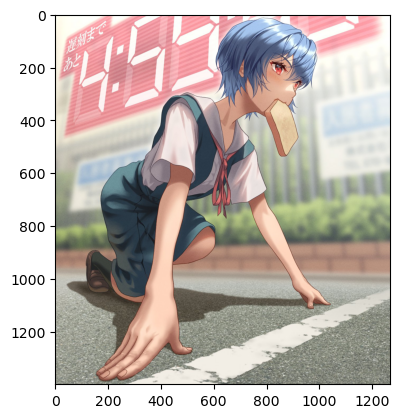

torch.Size([3, 232, 232])


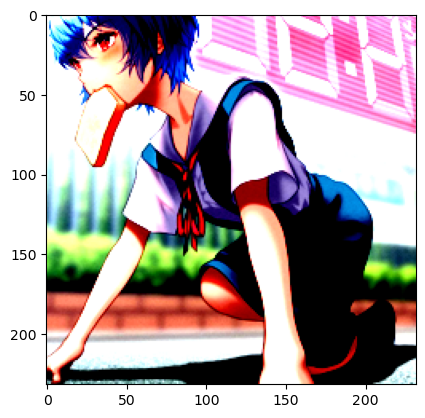

In [8]:
# 動作確認
img_path = images_path[0]
img = Image.open(img_path)
print(img.size)
plt.imshow(img)
plt.show()

size = 232
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")
print(img_transformed.shape)

# (色、高さ、幅)を(高さ、幅、色)に変化し、0－1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1) #limit (clip) the values in an array
plt.imshow(img_transformed)
plt.show()


In [9]:
# jpgのフォーマットしか使えない。
# リストにパスを格納
def make_datapath_list(base_dir):
    """
    データのパスを格納したリストを作成する
        
    Returns
    -------
    path_list : list
        データのパスを格納したリスト
    
    """
    target_path = os.path.join(base_dir+"/*.jpg")
    print(target_path)
    
    path_list = []
    #globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list
    
make_datapath_list('E:\\Data\\mobilenet\\images\\ayanami_rei')[0:20], len(make_datapath_list('E:\\Data\\mobilenet\\images\\ayanami_rei'))

E:\Data\mobilenet\images\ayanami_rei/*.jpg
E:\Data\mobilenet\images\ayanami_rei/*.jpg


(['E:\\Data\\mobilenet\\images\\ayanami_rei\\02556c9a75fcf7402f4c97d340922027d17a527c.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\02e8f8d0b8c776844d0c09fc961aef696c88d695.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0388564845bf7eb88c4f5f19f1651ad31131442f.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\05c8d268052ceb0fee405086c9f063db1664a03e.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0894fb8b55b6c082d81582df62d74bf65f7946a1.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\093d277c20cf294e6235d965b3993c02ed9e416f.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0971091ad082dd8f2cd23fff4884944ddec6b2fc.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\09e7df7dd36e1f5a710547d96d284b4f2b1a5f61.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0b036ea70ddca109445b942883b4b9f8d9256e47.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0bf165f84028445bd83426b7b8edbe74a64dd808.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0e26c7d439467697ee54ffc63c75257aec1

In [10]:
# 訓練と検証を分割する
def split_train_val(base_dir, train_ration=0.8):
    
    train_paths = []
    val_paths = []
    # 最初はフォルダの名前を格納する
    folders_list = get_filenames(base_dir)
    
    for folder in folders_list:
        paths_list = make_datapath_list(folder)
        
        random.shuffle(paths_list)
        
        # 分割比率を使って
        total_samples = len(paths_list)
        train_samples = int(train_ration * total_samples)
        
        # リストを訓練データと検証データに分割
        train_data = paths_list[:train_samples]
        val_data = paths_list[train_samples:]
        
        train_paths.extend(train_data)
        val_paths.extend(val_data)
    
    return train_paths, val_paths

base_dir = "E:\Data\mobilenet\images"
train_list, val_list = split_train_val(base_dir)
len(train_list), len(val_list), val_list[0:50]

E:\Data\mobilenet\images\ayanami_rei/*.jpg
E:\Data\mobilenet\images\ikari_shinji/*.jpg
E:\Data\mobilenet\images\makinami_mari_illustrious/*.jpg
E:\Data\mobilenet\images\nagisa_kaworu/*.jpg
E:\Data\mobilenet\images\souryuu_asuka_langley/*.jpg


(625,
 159,
 ['E:\\Data\\mobilenet\\images\\ayanami_rei\\dd93f0e11341383c7ef858ad8dc032dd42985b43.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\7372db0e3c94c7a86dc188972599e182d7851d89.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0f0c99b0bc726ef55a0dba91d7c7ab3d6c9b6815.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\d4faaecdb9b475bd058bd29ad7f6b7f898bc4667.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\2577bb1825f2191e4ec6e4bbfedcc05887af7637.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\1c4be2c7fa438ca887997a7b1c9cd06e5b46e923.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\bf7a525c30cf5b36d9eaebaff84da765222def91.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\dd27906a0166ff1a1532ca4932eae20027898ace.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\1c3b7aabd9132ca32949917cff3646eb140f3ca3.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\6951714ce4c3db3161db870688f6a82a1b6e877a.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\ca1821f860902b65b06781b

In [11]:
# エヴァンゲリオンのパイロットクラスを作成する

class Pilots(Dataset):
    
    def __init__(self, file_list, labels_dict, transform=None, phase="train"):
        self.file_list = file_list
        self.transforms = transform
        self.phase = phase
        
        # 辞書型からラベルをエンコードする
        self.labels_dict = labels_dict
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        
        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path) # [高さ][幅][色RGB]
        
        # 画像の前処理を実施
        img_transformed = self.transforms(img, self.phase) # torch.Size([3, 232, 232])
        
        label = os.path.basename(os.path.dirname(img_path))
        
        label = self.labels_dict[label]
        
        return img_transformed, label

In [12]:
pilots_labels = {"ayanami_rei": 0, "ikari_shinji": 1, "makinami_mari_illustrious": 2,
                "nagisa_kaworu": 3, "souryuu_asuka_langley": 4}

In [13]:
# ラベルの作り方について
img_path = ['E:\\Data\\mobilenet\\images\\ayanami_rei\\dd93f0e11341383c7ef858ad8dc032dd42985b43.jpg',
    'E:\\Data\\mobilenet\\images\\ikari_shinji\\3ef112c427c6ecae2018c3db18fc547b63d6a5de.jpg',]
labels = []

for path in img_path:
    print(path)
    print(os.path.dirname(path))
    name = os.path.basename(os.path.dirname(path))
    labels.append(name)
    
print(labels) 

E:\Data\mobilenet\images\ayanami_rei\dd93f0e11341383c7ef858ad8dc032dd42985b43.jpg
E:\Data\mobilenet\images\ayanami_rei
E:\Data\mobilenet\images\ikari_shinji\3ef112c427c6ecae2018c3db18fc547b63d6a5de.jpg
E:\Data\mobilenet\images\ikari_shinji
['ayanami_rei', 'ikari_shinji']


In [14]:
# 辞書型からラベルの値を取得する、名前を値に変えて
for i in range(len(labels)):
    labels[i] = pilots_labels[labels[i]]

print(labels)

[0, 1]


In [15]:
# Datasetを作成する
size = 232
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
pilots_labels = {"ayanami_rei": 0, "ikari_shinji": 1, "makinami_mari_illustrious": 2,
                "nagisa_kaworu": 3, "souryuu_asuka_langley": 4}

# 実行する
train_dataset = Pilots(file_list=train_list, labels_dict=pilots_labels,
                      transform=ImageTransform(size, mean, std), phase="train")

val_dataset = Pilots(file_list=val_list, labels_dict=pilots_labels,
                      transform=ImageTransform(size, mean, std), phase="val")

print(train_dataset.__getitem__(220)[0].size()) # 画像
print(train_dataset.__getitem__(220)[1]) # ラベル


torch.Size([3, 232, 232])
1


In [16]:
# DataLoaderを作成する
batch_size = 90 # 6 Gb VRAM

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloder = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloder}

#動作を確認
batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(batch_iterator)
print(inputs.size(), inputs.shape)
print(labels)

torch.Size([90, 3, 232, 232]) torch.Size([90, 3, 232, 232])
tensor([3, 2, 2, 3, 2, 2, 4, 0, 4, 2, 1, 4, 2, 3, 2, 2, 1, 4, 3, 4, 0, 3, 1, 2,
        1, 0, 2, 0, 2, 0, 4, 3, 2, 1, 0, 3, 0, 4, 2, 3, 3, 4, 2, 1, 1, 4, 1, 2,
        4, 3, 4, 0, 2, 2, 0, 3, 2, 1, 1, 1, 2, 4, 3, 1, 4, 1, 1, 2, 4, 2, 4, 0,
        3, 0, 3, 0, 2, 0, 4, 1, 1, 1, 0, 4, 4, 2, 1, 0, 3, 0])


In [17]:
mobilenet = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)

In [18]:
torchinfo.summary(mobilenet, inputs.shape, depth=2)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [90, 1000]                --
├─Sequential: 1-1                                  [90, 960, 8, 8]           --
│    └─Conv2dNormActivation: 2-1                   [90, 16, 116, 116]        464
│    └─InvertedResidual: 2-2                       [90, 16, 116, 116]        464
│    └─InvertedResidual: 2-3                       [90, 24, 58, 58]          3,440
│    └─InvertedResidual: 2-4                       [90, 24, 58, 58]          4,440
│    └─InvertedResidual: 2-5                       [90, 40, 29, 29]          10,328
│    └─InvertedResidual: 2-6                       [90, 40, 29, 29]          20,992
│    └─InvertedResidual: 2-7                       [90, 40, 29, 29]          20,992
│    └─InvertedResidual: 2-8                       [90, 80, 15, 15]          32,080
│    └─InvertedResidual: 2-9                       [90, 80, 15, 15]          34,760
│    └─

In [19]:
torchinfo.summary(mobilenet, inputs.shape, depth=4)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [90, 1000]                --
├─Sequential: 1-1                                  [90, 960, 8, 8]           --
│    └─Conv2dNormActivation: 2-1                   [90, 16, 116, 116]        --
│    │    └─Conv2d: 3-1                            [90, 16, 116, 116]        432
│    │    └─BatchNorm2d: 3-2                       [90, 16, 116, 116]        32
│    │    └─Hardswish: 3-3                         [90, 16, 116, 116]        --
│    └─InvertedResidual: 2-2                       [90, 16, 116, 116]        --
│    │    └─Sequential: 3-4                        [90, 16, 116, 116]        --
│    │    │    └─Conv2dNormActivation: 4-1         [90, 16, 116, 116]        176
│    │    │    └─Conv2dNormActivation: 4-2         [90, 16, 116, 116]        288
│    └─InvertedResidual: 2-3                       [90, 24, 58, 58]          --
│    │    └─Sequential: 3-5     

In [20]:
torchinfo.summary(mobilenet, inputs.shape, depth=5)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [90, 1000]                --
├─Sequential: 1-1                                  [90, 960, 8, 8]           --
│    └─Conv2dNormActivation: 2-1                   [90, 16, 116, 116]        --
│    │    └─Conv2d: 3-1                            [90, 16, 116, 116]        432
│    │    └─BatchNorm2d: 3-2                       [90, 16, 116, 116]        32
│    │    └─Hardswish: 3-3                         [90, 16, 116, 116]        --
│    └─InvertedResidual: 2-2                       [90, 16, 116, 116]        --
│    │    └─Sequential: 3-4                        [90, 16, 116, 116]        --
│    │    │    └─Conv2dNormActivation: 4-1         [90, 16, 116, 116]        --
│    │    │    │    └─Conv2d: 5-1                  [90, 16, 116, 116]        144
│    │    │    │    └─BatchNorm2d: 5-2             [90, 16, 116, 116]        32
│    │    │    │    └─ReLU: 5-3  

In [21]:
print(mobilenet)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [22]:
# 学習済みモデルの出力を変える
mobilenet.classifier[3] = nn.Linear(in_features=1280, out_features=len(pilots_labels), bias=True)
mobilenet.train()

print(mobilenet)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [23]:
# 損失関数の定義
criterion = nn.CrossEntropyLoss(reduction="mean")

In [24]:
# # ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 学習させる層のパラメータ名を定義
update_param_names1 = ["features"]
update_param_names2 = ["classifier.0.weight", "classifier.0.bias"]
update_param_names3 = ["classifier.3.weight", "classifier.3.bias"]

# パラメータごとに各リストに格納する
for name, param in mobilenet.named_parameters():
    if update_param_names1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納: ", name)
    
    elif name in update_param_names2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納: ", name)
    
    elif name in update_param_names3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納: ", name)
    
    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)


params_to_update_1に格納:  features.0.0.weight
params_to_update_1に格納:  features.0.1.weight
params_to_update_1に格納:  features.0.1.bias
params_to_update_1に格納:  features.1.block.0.0.weight
params_to_update_1に格納:  features.1.block.0.1.weight
params_to_update_1に格納:  features.1.block.0.1.bias
params_to_update_1に格納:  features.1.block.1.0.weight
params_to_update_1に格納:  features.1.block.1.1.weight
params_to_update_1に格納:  features.1.block.1.1.bias
params_to_update_1に格納:  features.2.block.0.0.weight
params_to_update_1に格納:  features.2.block.0.1.weight
params_to_update_1に格納:  features.2.block.0.1.bias
params_to_update_1に格納:  features.2.block.1.0.weight
params_to_update_1に格納:  features.2.block.1.1.weight
params_to_update_1に格納:  features.2.block.1.1.bias
params_to_update_1に格納:  features.2.block.2.0.weight
params_to_update_1に格納:  features.2.block.2.1.weight
params_to_update_1に格納:  features.2.block.2.1.bias
params_to_update_1に格納:  features.3.block.0.0.weight
params_to_update_1に格納:  features.3.block.0.1.wei

In [25]:
# 最適化手法の設定
optimizer = optim.Adam([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 3e-4},
    {'params': params_to_update_3, 'lr': 1e-3},
], weight_decay=0.001)

# スケジューラーの定義
def lambda_epoch(epoch):
    max_epoch = 20
    return math.pow((1-epoch/max_epoch), 0.9)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)


In [26]:
# モデルを学習させる関数

def train_one_epoch(model, dataloaders_dict, criterion, optimizer, scheduler, device, phase, epoch):
    
    if phase == 'train':
        model.train()
        # 最適化schedulerの更新、最初のエポックは使えないすべき
        if epoch > 0:
            # エポックごとlrを小さくしてくる
            scheduler.step()
        # 勾配をゼロにして
        optimizer.zero_grad()    
        
    else:
        model.eval()
        
    epoch_loss = 0.0
    epoch_corrects = 0
    
    pbar = tqdm(dataloaders_dict[phase])
    for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        
        # optimizerを初期化
        optimizer.zero_grad() 
        
        # 順伝搬計算
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            # outputsはロジットから値の一番高いをとる、CrossEntropyLossはシグモイド関数を使うからロジットで大丈夫
            
            _, preds = torch.max(outputs, 1)
            
            # 訓練時はバックプロパゲーション
            if phase == 'train':
                # 勾配を計算して
                loss.backward()
                # paramを更新して
                optimizer.step()
                
            epoch_loss += loss.item() * imgs.size(0) # lossの合計を更新
            # 正解ラベルの合計
            epoch_corrects += torch.sum(preds == labels.data)
            
            pbar.set_description(f"loss: {loss}")
            
    return epoch_loss, epoch_corrects
        

In [27]:
num_epochs = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mobilenet = mobilenet.to(device)

for epoch in range(num_epochs):
    print("="*10)
    print(f"start {epoch+1} epochs training")
    
    phase = 'train'
    
    epoch_loss, epoch_corrects = train_one_epoch(mobilenet, dataloaders_dict, criterion, optimizer, scheduler, device, phase, epoch)

    # epochごとのlossと正解率を表示
    epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
    epoch_acc = epoch_corrects.double(
    ) / len(dataloaders_dict[phase].dataset)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))
    
    # 全部のエポックは検証したくない
    if epoch % 3 == 0:
        phase = 'val'
        epoch_loss, epoch_corrects = train_one_epoch(mobilenet, dataloaders_dict, criterion, optimizer, scheduler, device, phase, epoch)

        # epochごとのlossと正解率を表示
        epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = epoch_corrects.double(
        ) / len(dataloaders_dict[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

start 1 epochs training


loss: 1.5338579416275024:  43%|████▎     | 3/7 [00:25<00:35,  8.85s/it]C:\Users\Victor\anaconda3\envs\Torch\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (96509232 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
loss: 1.325874924659729: 100%|██████████| 7/7 [01:05<00:00,  9.33s/it] 


train Loss: 1.4698 Acc: 0.4096


loss: 1.481801152229309: 100%|██████████| 2/2 [00:17<00:00,  8.81s/it] 


val Loss: 1.4204 Acc: 0.3522
start 2 epochs training


loss: 0.7950384020805359: 100%|██████████| 7/7 [00:41<00:00,  5.94s/it]


train Loss: 1.0394 Acc: 0.7024
start 3 epochs training


loss: 0.5676440000534058: 100%|██████████| 7/7 [00:41<00:00,  5.94s/it]


train Loss: 0.6674 Acc: 0.7968
start 4 epochs training


loss: 0.35290274024009705: 100%|██████████| 7/7 [00:42<00:00,  6.00s/it]


train Loss: 0.4754 Acc: 0.8448


loss: 1.4428646564483643: 100%|██████████| 2/2 [00:08<00:00,  4.47s/it]


val Loss: 1.3019 Acc: 0.5660
start 5 epochs training


loss: 0.2570025622844696: 100%|██████████| 7/7 [00:41<00:00,  5.95s/it] 


train Loss: 0.3199 Acc: 0.8976
start 6 epochs training


loss: 0.22059033811092377: 100%|██████████| 7/7 [00:42<00:00,  6.05s/it]


train Loss: 0.2465 Acc: 0.9152
start 7 epochs training


loss: 0.19548654556274414: 100%|██████████| 7/7 [00:41<00:00,  6.00s/it]


train Loss: 0.1920 Acc: 0.9424


loss: 1.2002917528152466: 100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


val Loss: 1.0718 Acc: 0.6604
start 8 epochs training


loss: 0.1167183592915535: 100%|██████████| 7/7 [00:43<00:00,  6.25s/it] 


train Loss: 0.1478 Acc: 0.9600
start 9 epochs training


loss: 0.0823981985449791: 100%|██████████| 7/7 [00:42<00:00,  6.04s/it] 


train Loss: 0.1191 Acc: 0.9680
start 10 epochs training


loss: 0.09048715233802795: 100%|██████████| 7/7 [00:42<00:00,  6.13s/it]


train Loss: 0.1111 Acc: 0.9664


loss: 1.2008520364761353: 100%|██████████| 2/2 [00:08<00:00,  4.49s/it]


val Loss: 1.0526 Acc: 0.6855
start 11 epochs training


loss: 0.06833412498235703: 100%|██████████| 7/7 [00:42<00:00,  6.12s/it]


train Loss: 0.0882 Acc: 0.9712
start 12 epochs training


loss: 0.10881412774324417: 100%|██████████| 7/7 [00:43<00:00,  6.15s/it] 


train Loss: 0.0811 Acc: 0.9776
start 13 epochs training


loss: 0.0670003890991211: 100%|██████████| 7/7 [00:43<00:00,  6.19s/it]  


train Loss: 0.0823 Acc: 0.9696


loss: 0.8648205995559692: 100%|██████████| 2/2 [00:09<00:00,  4.56s/it]


val Loss: 0.8508 Acc: 0.7358
start 14 epochs training


loss: 0.10482572764158249: 100%|██████████| 7/7 [00:42<00:00,  6.13s/it]


train Loss: 0.0560 Acc: 0.9824
start 15 epochs training


loss: 0.09307795017957687: 100%|██████████| 7/7 [00:43<00:00,  6.18s/it] 


train Loss: 0.0609 Acc: 0.9840
start 16 epochs training


loss: 0.02863488160073757: 100%|██████████| 7/7 [00:43<00:00,  6.18s/it] 


train Loss: 0.0553 Acc: 0.9888


loss: 0.6444851160049438: 100%|██████████| 2/2 [00:08<00:00,  4.49s/it]


val Loss: 0.6977 Acc: 0.7987
start 17 epochs training


loss: 0.023920364677906036: 100%|██████████| 7/7 [00:43<00:00,  6.16s/it]


train Loss: 0.0676 Acc: 0.9792
start 18 epochs training


loss: 0.04847240447998047: 100%|██████████| 7/7 [00:43<00:00,  6.18s/it] 


train Loss: 0.0353 Acc: 0.9904
start 19 epochs training


loss: 0.07245426625013351: 100%|██████████| 7/7 [00:43<00:00,  6.22s/it] 


train Loss: 0.0549 Acc: 0.9776


loss: 0.6950889825820923: 100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


val Loss: 0.6287 Acc: 0.8050
start 20 epochs training


loss: 0.07616335153579712: 100%|██████████| 7/7 [00:42<00:00,  6.12s/it] 

train Loss: 0.0472 Acc: 0.9872


In [28]:
# PyTorchのネットワークパラメータの保存
save_path = './fine_tuning.pth'
torch.save(mobilenet.state_dict(), save_path)


In [6]:
pilots_labels = {"ayanami_rei": 0, "ikari_shinji": 1, "makinami_mari_illustrious": 2,
                "nagisa_kaworu": 3, "souryuu_asuka_langley": 4}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobilenet = models.mobilenet_v3_large()
mobilenet.classifier[3] = nn.Linear(in_features=1280, out_features=len(pilots_labels), bias=True)


In [7]:

# PyTorchのネットワークパラメータのロード
load_path = './fine_tuning.pth'
load_weights = torch.load(load_path)
mobilenet.load_state_dict(load_weights)

mobilenet.to(device)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

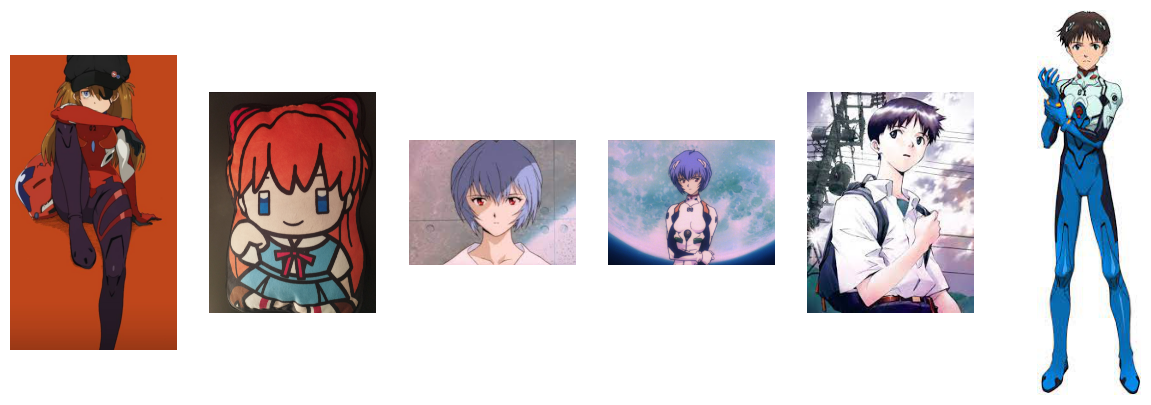

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images(image_paths):
    num_images = len(image_paths)
    
    # Set up subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i, path in enumerate(image_paths):
        # Load and display the image
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
    
    plt.show()
# フォルダの画像数枚を数える
def get_filenames(img_dir):
    image_filenames = os.listdir(img_dir)
    image_filenames = [os.path.join(img_dir, img) for img in image_filenames]
    
    return image_filenames

# Example usage
path = "C:\\Users\\Victor\\Pictures\\pilots"
images_path = get_filenames(path)

plot_images(images_path)


In [15]:
# 推論

size = 232
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = ImageTransform(size, mean, std)

imgs = []

for img_path in images_path:
    img = Image.open(img_path)
    img_transformed = transform(img, phase="val")
    imgs.append(img_transformed)
    
imgs = np.stack(imgs)  # Stack images into a single numpy array

tensor = torch.from_numpy(imgs)
print(tensor.shape)
mobilenet.eval()

        
outputs = mobilenet(tensor.to(device))
_, preds = torch.max(outputs, 1)

print(preds)
for label in preds:
    print(list(pilots_labels.keys())[list(pilots_labels.values()).index(label)])

torch.Size([6, 3, 232, 232])
tensor([4, 4, 0, 0, 1, 1], device='cuda:0')
souryuu_asuka_langley
souryuu_asuka_langley
ayanami_rei
ayanami_rei
ikari_shinji
ikari_shinji
